# 1. Import packages and Global parameters setting

In [1]:
import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt

from copy import deepcopy

ITERATIONS = 10
CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

In [2]:
import cvxpy as cp
import numpy as np
import time

x1 = cp.Variable(1)
x2 = cp.Variable(1)
x3 = cp.Variable(1)
objective = cp.abs(2.3*x1 +x3 -3.5)+cp.abs(x2 +2*x3-1.8)+cp.abs(1.3*x1 +x2 +x3 +3)
g = x1**2 - x2 +x3 +3
h1 = x1+x2+x3
h2 = 2*x2 + x3
problem = cp.Problem(cp.Minimize(objective), [g <= 0.0, h1 == 0, h2 == 2])
t0 = time.time()
problem.solve(solver='SCS')
print('time: ' + str(time.time()-t0))
print(problem.value)
print(x1.value, x2.value, x3.value)

time: 0.071319580078125
11.391567366652682
[-0.30281097] [1.69718917] [-1.3943782]


# 2. The 5th NCP

In [3]:
# Qin, 2014 TNNLS, example 1
nx = 3
nu = 1
NY = nx+nu

xu0 = jnp.array([-0.6, 1, -0.2, 1.2])
A = jnp.array([[1., 1., 1.],
         [0, 2, 1.]])
b = jnp.array([0., 2.])
PM = A.T@jnp.linalg.inv(A@A.T)@A

def f(x):
    x1, x2, x3 = x[0], x[1], x[2]

    output = jnp.abs(2.3*x1+1*x3-3.5) + jnp.abs(x2+2*x3-1.8) + jnp.abs(1.3*x1+x2+x3+3)
    return output

def g(x):
    x1, x2, x3 = x[0], x[1], x[2]
    g1 = x1**2 - x2 + x3 +3
    output = jnp.array([g1])
    return output

def h(x):
    output = jnp.clip(A@x-b, a_min=-1, a_max=1)

    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    x, u = xu[:nx].reshape((nx,)), xu[nx:].reshape((nu,))
    x = x - (A.T@jnp.linalg.inv(A@A.T))@((A@x-b).reshape((-1, )))
    u = np.clip(u, a_min=0, a_max=None)
    output = np.concatenate([x, u], axis=0)
    return output

In [6]:
def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -(jnp.identity(nx) - PM)@dx - A.T@h(x)
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, \
        f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0).all():
        obj = f(x)
    else:
        obj = np.inf
    return obj

sol = solve_ivp(ODE, [0., 100.], xu0, t_eval=np.arange(0, 100, 0.1), method='BDF')
result = P(sol.y[:, -1])
print(evalutation(result))
print(result)

11.391673
[-0.30277559  1.69722438 -1.39444876  0.8320501 ]


In [5]:
x, u = result[:nx], result[nx:]
error1 = df(x)+u@dg(x)
error1 = np.max(np.abs((error1)))
error2 = u-np.clip(u+g(x),a_min=0,a_max=None)
error2 = np.max(np.abs((error2)))
print(error1, error2)

1.5038489 7.159497839026585e-08


# 3. The method

In [10]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, 100)
        self.linear2 = nn.Linear(100, NY)

    def forward(self, x):
        t = x
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

class FNN_L(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN_L, self).__init__()
        self.linear1 = nn.Linear(1, 100)
        self.linear2 = nn.Linear(100, NY)

    def forward(self, x):
        t = x
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x

class NN_NOP_P:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE)
        self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()

        optimizer = Adam(net.parameters(), lr=LR)
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)
            
            if i==0: # if first iteration
                print(f'Predicted solution at iteration 0: {y_T}')

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            epsilon_best = epsilon_current
            y_T_best = y_T
            y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
            net_best = deepcopy(net)
            L_y_iterations.append(self.y_iteration(net_best))
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()

            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()

            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
            i = i+1
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        dy = self.vODE(t.cpu().detach().numpy(), y[:, :].cpu().detach().numpy())
        dy = np.array(dy)
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        physics_loss = mse(dy, pdy) # [NBATCH, NY]
        physics_loss = torch.sum(physics_loss, axis=1) # [NBATCH]
        
        y0_pred = net(torch.tensor([[0.]], dtype=torch.float).cuda())
        y0_tensor = torch.from_numpy(self.y0).to(dtype=torch.float).cuda()
        y0_tensor = y0_tensor.unsqueeze(0) 
        data_loss = mse(y0_tensor, y0_pred)
        data_loss = torch.sum(data_loss, axis=1)
        
        if weighting is not None:
            physics_loss = torch.exp(-weighting*t.detach().reshape((-1, )))*physics_loss # proprity smaller t
        loss = torch.mean(physics_loss, axis=0) + data_loss
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]

class NN_NOP_PL:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE)
        self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN_L(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()

        optimizer = Adam(net.parameters(), lr=LR)
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)
            
            if i==0: # if first iteration
                print(f'Predicted solution at iteration 0: {y_T}')

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            epsilon_best = epsilon_current
            y_T_best = y_T
            y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
            net_best = deepcopy(net)
            L_y_iterations.append(self.y_iteration(net_best))
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()

            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()

            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
            i = i+1
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        dy = self.vODE(t.cpu().detach().numpy(), y[:, :].cpu().detach().numpy())
        dy = np.array(dy)
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        loss = mse(dy, pdy) # [NBATCH, NY]
        loss = torch.sum(loss, axis=1) # [NBATCH]
        if weighting is not None:
            loss = torch.exp(-weighting*t.detach().reshape((-1, )))*loss # proprity smaller t
        loss = torch.mean(loss, axis=0)
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]

class NN_NOP_PLE:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE)
        self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN_L(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()

        optimizer = Adam(net.parameters(), lr=LR)
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                print(f'Predicted solution at iteration 0: {y_T}')
                epsilon_best = epsilon_current
                y_T_best = y_T
                y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()

            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()

            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
            i = i+1
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        dy = self.vODE(t.cpu().detach().numpy(), y[:, :].cpu().detach().numpy())
        dy = np.array(dy)
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        loss = mse(dy, pdy) # [NBATCH, NY]
        loss = torch.sum(loss, axis=1) # [NBATCH]
        if weighting is not None:
            loss = torch.exp(-weighting*t.detach().reshape((-1, )))*loss # proprity smaller t
        loss = torch.mean(loss, axis=0)
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [7]:
NBATCH = 512
ITERATIONS = 1000
LR=0.01

In [8]:
y0 = np.array([2., 3., -2., 1.])

In [9]:
NN_weights = FNN_L(y0)
t_L = [np.random.uniform(0, 10, (NBATCH, 1)) for _ in range(ITERATIONS)]

In [10]:

example_1_P= NN_NOP_P(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_P.NN_method(weights=NN_weights, t_L=t_L) # train
res_1_P = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-1.2918665   0.70813346  0.583733    0.39704776]
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 0, Loss: 30.7269,  epsilon_best: inf, y_T: [-1.2919  0.7081  0.5837  0.397 ], ||y_T_ODE-y_T_best||_2: 2.4657
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 100, Loss: 1.2820,  epsilon_best: 12.3412, y_T: [ 0.0137  2.0137 -2.0274  1.7484], ||y_T_ODE-y_T_best||_2: 1.1946
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 200, Loss: 0.2486,  epsilon_best: inf, y_T: [-0.3693  1.6307 -1.2613  1.1275], ||y_T_ODE-y_T_best||_2: 0.3351
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 300, Loss: 1.2536,  epsilon_best: 12.1243, y_T: [-0.0586  1.9414 -1.8829  0.0341], ||y_T_ODE-y_T_best||_2: 0.9989
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 400, Loss: 1.2809,  epsilon_best: 11.8384, 

In [11]:
example_1_PL= NN_NOP_PL(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PL.NN_method(weights=NN_weights, t_L=t_L) # train
res_1_PL = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [ 0.20814669  2.2081466  -2.4162936   1.3970298 ]
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 0, Loss: 3.2637,  epsilon_best: 12.9244, y_T: [ 0.2081  2.2081 -2.4163  1.397 ], ||y_T_ODE-y_T_best||_2: 1.3681
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 100, Loss: 0.1846,  epsilon_best: inf, y_T: [-0.5124  1.4876 -0.9751  1.0912], ||y_T_ODE-y_T_best||_2: 0.5763


T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 200, Loss: 0.0178,  epsilon_best: inf, y_T: [-0.3441  1.6559 -1.3119  0.5802], ||y_T_ODE-y_T_best||_2: 0.2769
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 300, Loss: 0.0047,  epsilon_best: 11.7007, y_T: [-0.1998  1.8002 -1.6005  0.8859], ||y_T_ODE-y_T_best||_2: 0.2537
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 400, Loss: 0.0064,  epsilon_best: 11.5580, y_T: [-0.2473  1.7527 -1.5054  0.8677], ||y_T_ODE-y_T_best||_2: 0.1360
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 500, Loss: 0.0046,  epsilon_best: 11.5130, y_T: [-0.2623  1.7377 -1.4753  0.8857], ||y_T_ODE-y_T_best||_2: 0.1074
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 600, Loss: 0.0034,  epsilon_best: 11.5465, y_T: [-0.2512  1.7488 -1.4977  0.9174], ||y_T_ODE-y_T_best||_2: 0.1471
T: 10, y_

In [12]:
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_1_PLE = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [ 0.20814669  2.2081466  -2.4162936   1.3970298 ]
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 0, Loss: 3.2637,  epsilon_best: 12.9244, y_T: [ 0.2081  2.2081 -2.4163  1.397 ], ||y_T_ODE-y_T_best||_2: 1.3681
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 100, Loss: 0.1846,  epsilon_best: 11.4866, y_T: [-0.2711  1.7289 -1.4577  0.9419], ||y_T_ODE-y_T_best||_2: 0.1287


T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 200, Loss: 0.0178,  epsilon_best: 11.4192, y_T: [-0.2936  1.7064 -1.4128  0.3418], ||y_T_ODE-y_T_best||_2: 0.4952
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 300, Loss: 0.0047,  epsilon_best: 11.4075, y_T: [-0.2975  1.7025 -1.405   0.6429], ||y_T_ODE-y_T_best||_2: 0.1940
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 400, Loss: 0.0064,  epsilon_best: 11.4075, y_T: [-0.2975  1.7025 -1.405   0.6429], ||y_T_ODE-y_T_best||_2: 0.1940
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 500, Loss: 0.0046,  epsilon_best: 11.4075, y_T: [-0.2975  1.7025 -1.405   0.6429], ||y_T_ODE-y_T_best||_2: 0.1940
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 600, Loss: 0.0034,  epsilon_best: 11.4071, y_T: [-0.2976  1.7024 -1.4048  0.7896], ||y_T_ODE-y_T_best||_2: 0.0479
T: 10

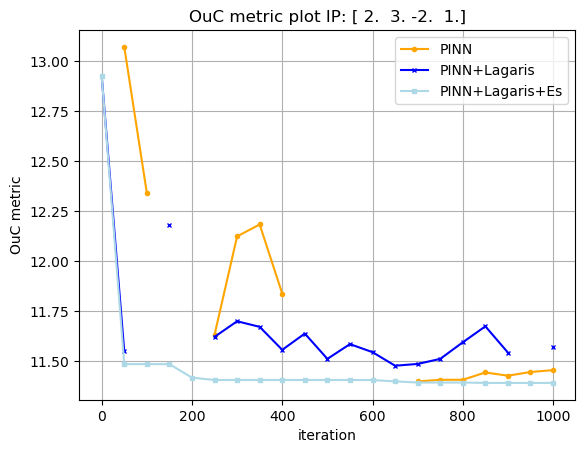

In [13]:
interval = 50

# Function to calculate indices and y_values for a given dataset
def get_plot_data(data, interval):
    indices = [i for i in range(0, len(data), interval)]
    indices.append(len(data) - 1)
    y_values = [data[i] for i in indices]
    return indices, y_values

# Get data for each dataset
indices_P, y_values_P = get_plot_data(res_1_P['L_epsilon'], interval)
indices_PL, y_values_PL = get_plot_data(res_1_PL['L_epsilon'], interval)
indices_PLE, y_values_PLE = get_plot_data(res_1_PLE['L_epsilon'], interval)

# Plot each dataset with labels
plt.plot(indices_P, y_values_P, marker='o', linestyle='-', color='orange', label='PINN', markersize=3)
plt.plot(indices_PL, y_values_PL, marker='x', linestyle='-', color='blue', label='PINN+Lagaris', markersize=3)
plt.plot(indices_PLE, y_values_PLE, marker='s', linestyle='-', color='lightblue', label='PINN+Lagaris+Es', markersize=3)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'OuC metric plot IP: {y0}')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()

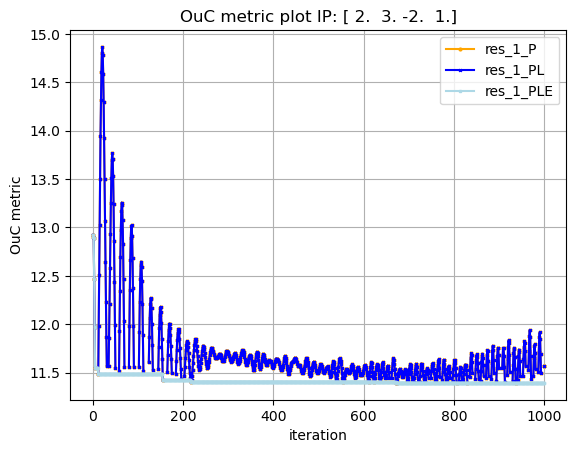

In [14]:
interval = 1

# Function to calculate indices and y_values for a given dataset
def get_plot_data(data, interval):
    indices = [i for i in range(0, len(data), interval)]
    indices.append(len(data) - 1)
    y_values = [data[i] for i in indices]
    return indices, y_values

# Get data for each dataset
indices_P, y_values_P = get_plot_data(res_1_PL['L_epsilon'], interval)
indices_PL, y_values_PL = get_plot_data(res_1_PLE['L_epsilon_curr'], interval)
indices_PLE, y_values_PLE = get_plot_data(res_1_PLE['L_epsilon'], interval)

# Plot each dataset with labels
plt.plot(indices_P, y_values_P, marker='o', linestyle='-', color='orange', label='res_1_P', markersize=2)
plt.plot(indices_PL, y_values_PL, marker='x', linestyle='-', color='blue', label='res_1_PL', markersize=2)
plt.plot(indices_PLE, y_values_PLE, marker='s', linestyle='-', color='lightblue', label='res_1_PLE', markersize=2)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'OuC metric plot IP: {y0}')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()

In [15]:
res_1_P['L_y_T_curr'][0], res_1_PL['L_y_T_curr'][0], res_1_PLE['L_y_T_curr'][0]

(array([-1.2918665 ,  0.70813346,  0.583733  ,  0.39704776], dtype=float32),
 array([ 0.20814669,  2.2081466 , -2.4162936 ,  1.3970298 ], dtype=float32),
 array([ 0.20814669,  2.2081466 , -2.4162936 ,  1.3970298 ], dtype=float32))

In [16]:

def format_solution(sol):
    return f"[{sol[0]:.2f} {sol[1]:.2f} {sol[2]:.2f} {sol[3]:.2f}]"

def format_ouc(ouc):
    return f"{ouc:.2f}" if ouc != float('inf') else "inf"

def print_table(res_1_P, res_1_PL, res_1_PLE):
    iterations = [0, 5, 10, 20, 40, 60, 80, 100]
    
    print(f"{'Iteration':<10}{'PINN':<40}{'PINN+Lagaris':<40}{'PINN+Lagaris+EC':<40}")
    print(f"{'':<10}{'Predicted solution':<20}{'OuC':<20}{'Predicted solution':<20}{'OuC':<20}{'Predicted solution':<20}{'OuC':<20}")
    
    for i in iterations:
        p_sol = format_solution(res_1_P['L_y_T'][i])
        p_ouc = format_ouc(res_1_P['L_epsilon'][i])
        
        pl_sol = format_solution(res_1_PL['L_y_T'][i])
        pl_ouc = format_ouc(res_1_PL['L_epsilon'][i])
        
        ple_sol = format_solution(res_1_PLE['L_y_T'][i])
        ple_ouc = format_ouc(res_1_PLE['L_epsilon'][i])
        
        print(f"{i:<10}{p_sol:<20}{p_ouc:<20}{pl_sol:<20}{pl_ouc:<20}{ple_sol:<20}{ple_ouc:<20}")

In [17]:
print(f"Initial point: {y0}")
print_table(res_1_P, res_1_PL, res_1_PLE)

Initial point: [ 2.  3. -2.  1.]
Iteration PINN                                    PINN+Lagaris                            PINN+Lagaris+EC                         
          Predicted solution  OuC                 Predicted solution  OuC                 Predicted solution  OuC                 
0         [-1.29 0.71 0.58 0.40]inf                 [0.21 2.21 -2.42 1.40]12.92               [0.21 2.21 -2.42 1.40]12.92               
5         [-1.07 0.93 0.14 2.36]inf                 [-0.25 1.75 -1.50 1.37]11.55               [-0.25 1.75 -1.50 1.37]11.55               
10        [-0.94 1.06 -0.11 4.14]inf                 [-0.49 1.51 -1.02 0.25]inf                 [-0.25 1.75 -1.50 1.37]11.55               
20        [-0.50 1.50 -0.99 3.60]inf                 [0.84 2.84 -3.67 3.12]14.81               [-0.27 1.73 -1.46 0.94]11.49               
40        [0.24 2.24 -2.49 2.13]13.03               [0.32 2.32 -2.63 2.83]13.25               [-0.27 1.73 -1.46 0.94]11.49               
60        [0

In [27]:
t_span = [0, 10]
t_eval = np.linspace(t_span[0], t_span[1], 100)
sol = solve_ivp(ODE, [0, 10], y0, method=NUMERICAL_METHOD, t_eval=t_eval)
y_ODE = sol.y


In [28]:
sol.y.shape

(4, 100)

In [37]:
t_eval.shape

(100,)

In [39]:
t_torch = torch.tensor(t_eval.reshape((-1, 1)), dtype=torch.float).cuda()

y_nn = net_best(t_torch)
y_nn = y_nn.T.cpu().detach().numpy()

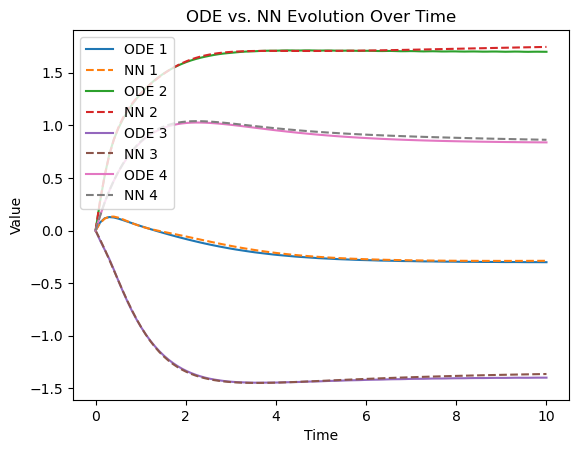

In [40]:
# Create a figure and axes
fig, ax = plt.subplots()

# Iterate and plot
for i in range(y_ODE.shape[0]):
    ax.plot(t_eval, y_ODE[i], label=f'ODE {i+1}')  # Adjust label as needed
    ax.plot(t_eval, y_nn[i], label=f'NN {i+1}', linestyle='--')  # Adjust label and style

# Add labels, legend, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('ODE vs. NN Evolution Over Time')
ax.legend()

# Display the plot
plt.show()

In [11]:
NBATCH = 512
ITERATIONS = 1000

In [12]:
y0 = np.array([2., 3., -2., 1.])
NN_weights = FNN_L(y0)
t_L = [np.random.uniform(0, 10, (NBATCH, 1)) for _ in range(ITERATIONS)]

In [13]:
LR=0.0001
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_1_0001 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-0.1622622   1.8377377  -1.6754758   0.44284362]
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 0, Loss: 3.2044,  epsilon_best: 11.8132, y_T: [-0.1623  1.8377 -1.6755  0.4428], ||y_T_ODE-y_T_best||_2: 0.5207
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 100, Loss: 0.9271,  epsilon_best: 11.8132, y_T: [-0.1623  1.8377 -1.6755  0.4428], ||y_T_ODE-y_T_best||_2: 0.5207
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 200, Loss: 1.1745,  epsilon_best: 11.6612, y_T: [-0.2129  1.7871 -1.5741  1.0619], ||y_T_ODE-y_T_best||_2: 0.3125
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 300, Loss: 0.9284,  epsilon_best: 11.3926, y_T: [-0.3025  1.6975 -1.3951  1.0068], ||y_T_ODE-y_T_best||_2: 0.1702
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 400, Loss: 0.8430,  epsilon_best: 11

In [14]:
LR=0.0001
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_1_0001 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-0.1622622   1.8377377  -1.6754758   0.44284362]
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 0, Loss: 3.2044,  epsilon_best: 11.8132, y_T: [-0.1623  1.8377 -1.6755  0.4428], ||y_T_ODE-y_T_best||_2: 0.5207
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 100, Loss: 0.9271,  epsilon_best: 11.8132, y_T: [-0.1623  1.8377 -1.6755  0.4428], ||y_T_ODE-y_T_best||_2: 0.5207
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 200, Loss: 1.1745,  epsilon_best: 11.6612, y_T: [-0.2129  1.7871 -1.5741  1.0619], ||y_T_ODE-y_T_best||_2: 0.3125
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 300, Loss: 0.9284,  epsilon_best: 11.3926, y_T: [-0.3025  1.6975 -1.3951  1.0068], ||y_T_ODE-y_T_best||_2: 0.1702
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 400, Loss: 0.8430,  epsilon_best: 11

In [15]:
LR=0.001
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_1_001 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-0.1622622   1.8377377  -1.6754758   0.44284362]
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 0, Loss: 3.2044,  epsilon_best: 11.8132, y_T: [-0.1623  1.8377 -1.6755  0.4428], ||y_T_ODE-y_T_best||_2: 0.5207
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 100, Loss: 0.9063,  epsilon_best: 11.4125, y_T: [-0.2958  1.7042 -1.4083  1.0236], ||y_T_ODE-y_T_best||_2: 0.1874
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 200, Loss: 0.3694,  epsilon_best: 11.4125, y_T: [-0.2958  1.7042 -1.4083  1.0236], ||y_T_ODE-y_T_best||_2: 0.1874
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 300, Loss: 0.1607,  epsilon_best: 11.4125, y_T: [-0.2958  1.7042 -1.4083  1.0236], ||y_T_ODE-y_T_best||_2: 0.1874
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 400, Loss: 0.1482,  epsilon_best: 11

In [16]:
LR=0.01
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_1_01 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-0.1622622   1.8377377  -1.6754758   0.44284362]
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 0, Loss: 3.2044,  epsilon_best: 11.8132, y_T: [-0.1623  1.8377 -1.6755  0.4428], ||y_T_ODE-y_T_best||_2: 0.5207
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 100, Loss: 0.1481,  epsilon_best: 11.3974, y_T: [-0.3009  1.6991 -1.3983  0.    ], ||y_T_ODE-y_T_best||_2: 0.8366
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 200, Loss: 0.0128,  epsilon_best: 11.3974, y_T: [-0.3009  1.6991 -1.3983  0.    ], ||y_T_ODE-y_T_best||_2: 0.8366
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 300, Loss: 0.0034,  epsilon_best: 11.3949, y_T: [-0.3017  1.6983 -1.3966  0.7497], ||y_T_ODE-y_T_best||_2: 0.0869
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 400, Loss: 0.0119,  epsilon_best: 11

In [17]:
LR=0.1
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_1_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-0.1622622   1.8377377  -1.6754758   0.44284362]
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 0, Loss: 3.2044,  epsilon_best: 11.8132, y_T: [-0.1623  1.8377 -1.6755  0.4428], ||y_T_ODE-y_T_best||_2: 0.5207
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 100, Loss: 0.0439,  epsilon_best: 11.3968, y_T: [-0.3011  1.6989 -1.3978  2.1188], ||y_T_ODE-y_T_best||_2: 1.2822
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 200, Loss: 0.0115,  epsilon_best: 11.3968, y_T: [-0.3011  1.6989 -1.3978  2.1188], ||y_T_ODE-y_T_best||_2: 1.2822
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 300, Loss: 0.0319,  epsilon_best: 11.3922, y_T: [-0.3026  1.6974 -1.3948  0.853 ], ||y_T_ODE-y_T_best||_2: 0.0167
T: 10, y_T_ODE: [-0.3014  1.6986 -1.3973  0.8366], epsilon_ODE: 11.3959,  Iteration: 400, Loss: 0.0163,  epsilon_best: 11

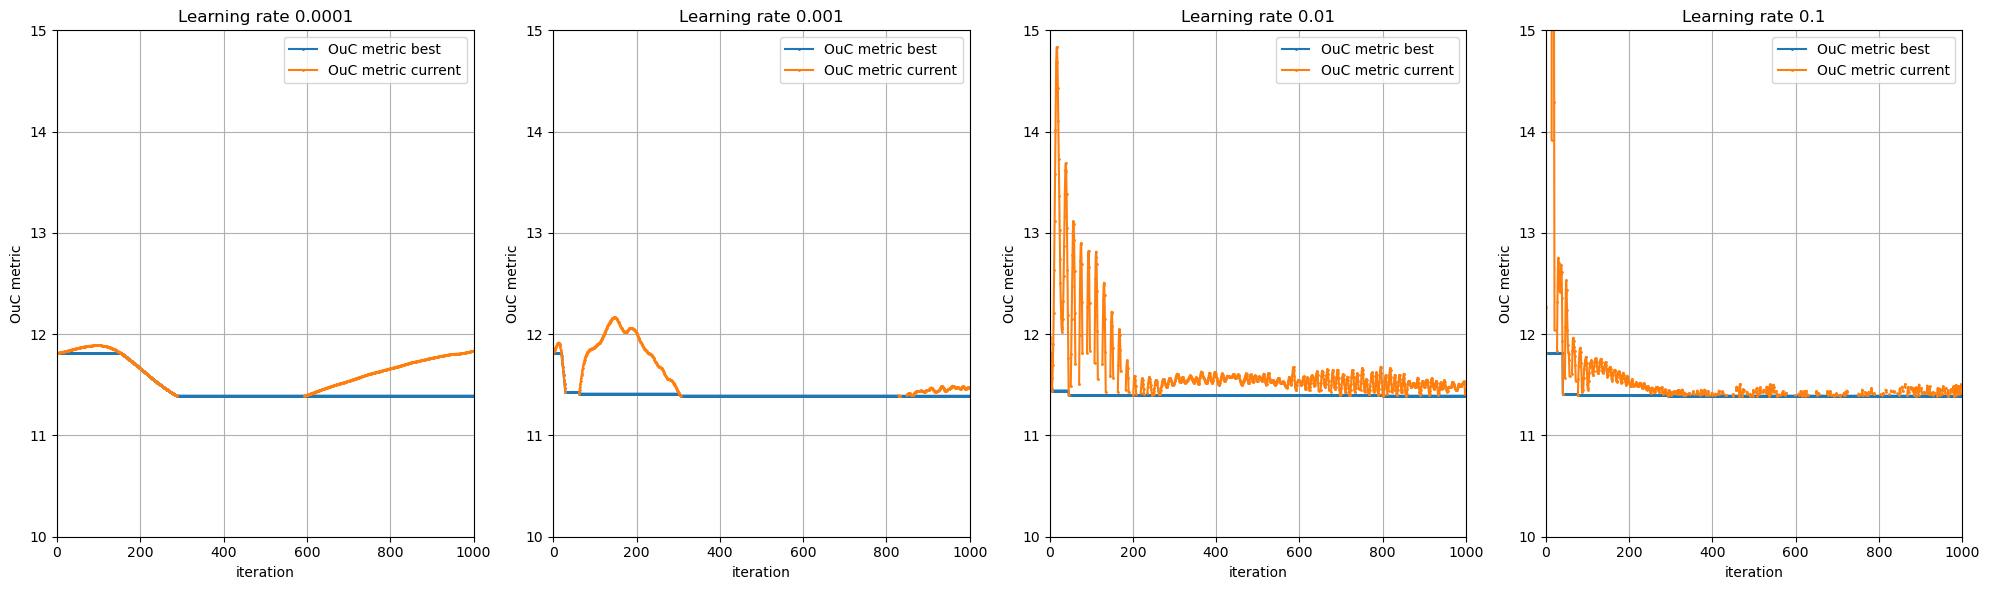

In [20]:
import matplotlib.pyplot as plt

# Assuming you have your dataframes res_L_1, res_L_2, res_L_3 ready

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 3 columns

y_min = 10
y_max = 15

# Plot on the first subplot
axes[0].plot(res_1_0001['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[0].plot(res_1_0001['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('OuC metric')
axes[0].set_title('Learning rate 0.0001')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlim(0, 1000)

# Plot on the second subplot (assuming similar structure for res_L_2)
axes[1].plot(res_1_001['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[1].plot(res_1_001['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('OuC metric')
axes[1].set_title('Learning rate 0.001')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlim(0, 1000)

# Plot on the third subplot (assuming similar structure for res_L_3)
axes[2].plot(res_1_01['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[2].plot(res_1_01['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[2].set_xlabel('iteration')
axes[2].set_ylabel('OuC metric')
axes[2].set_title('Learning rate 0.01')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(y_min, y_max)
axes[2].set_xlim(0, 1000)

# Plot on the third subplot (assuming similar structure for res_L_3)
axes[3].plot(res_1_1['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[3].plot(res_1_1['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[3].set_xlabel('iteration')
axes[3].set_ylabel('OuC metric')
axes[3].set_title('Learning rate 0.1')
axes[3].legend()
axes[3].grid(True)
axes[3].set_ylim(y_min, y_max)
axes[3].set_xlim(0, 1000)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
y0 = np.array([2., -2., 1., -2.])
NN_weights = FNN_L(y0)
t_L = [np.random.uniform(0, 10, (NBATCH, 1)) for _ in range(ITERATIONS)]

In [26]:
LR=0.0001
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_2_0001 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-1.1557488   0.84425116  0.3114977   0.        ]
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 0, Loss: 10.5568,  epsilon_best: inf, y_T: [-1.1557  0.8443  0.3115  0.    ], ||y_T_ODE-y_T_best||_2: 2.3575
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 100, Loss: 5.3576,  epsilon_best: inf, y_T: [-1.1557  0.8443  0.3115  0.    ], ||y_T_ODE-y_T_best||_2: 2.3575
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 200, Loss: 5.5356,  epsilon_best: inf, y_T: [-1.1557  0.8443  0.3115  0.    ], ||y_T_ODE-y_T_best||_2: 2.3575
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 300, Loss: 4.4402,  epsilon_best: inf, y_T: [-1.1557  0.8443  0.3115  0.    ], ||y_T_ODE-y_T_best||_2: 2.3575
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 400, Loss: 3.8136,  epsilon_best: inf, y_T: [-1.155

In [27]:
LR=0.001
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_2_001 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-1.1557488   0.84425116  0.3114977   0.        ]
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 0, Loss: 10.5568,  epsilon_best: inf, y_T: [-1.1557  0.8443  0.3115  0.    ], ||y_T_ODE-y_T_best||_2: 2.3575
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 100, Loss: 0.5734,  epsilon_best: 11.5154, y_T: [-0.2615  1.7385 -1.4769  2.6535], ||y_T_ODE-y_T_best||_2: 1.7259
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 200, Loss: 0.1450,  epsilon_best: 11.5154, y_T: [-0.2615  1.7385 -1.4769  2.6535], ||y_T_ODE-y_T_best||_2: 1.7259
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 300, Loss: 0.1237,  epsilon_best: 11.5154, y_T: [-0.2615  1.7385 -1.4769  2.6535], ||y_T_ODE-y_T_best||_2: 1.7259
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 400, Loss: 0.0932,  epsilon_best: 11.51

In [28]:
LR=0.01
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_2_01 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-1.1557488   0.84425116  0.3114977   0.        ]
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 0, Loss: 10.5568,  epsilon_best: inf, y_T: [-1.1557  0.8443  0.3115  0.    ], ||y_T_ODE-y_T_best||_2: 2.3575
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 100, Loss: 0.0659,  epsilon_best: 12.5007, y_T: [ 0.0669  2.0669 -2.1338  5.4945], ||y_T_ODE-y_T_best||_2: 4.6410
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 200, Loss: 0.0598,  epsilon_best: 12.5007, y_T: [ 0.0669  2.0669 -2.1338  5.4945], ||y_T_ODE-y_T_best||_2: 4.6410
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 300, Loss: 0.0470,  epsilon_best: 12.5007, y_T: [ 0.0669  2.0669 -2.1338  5.4945], ||y_T_ODE-y_T_best||_2: 4.6410
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 400, Loss: 0.0393,  epsilon_best: 11.85

In [29]:
LR=0.1
example_1_PLE= NN_NOP_PLE(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1_PLE.NN_method(weights=NN_weights, t_L=t_L) # train
res_2_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

Predicted solution at iteration 0: [-1.1557488   0.84425116  0.3114977   0.        ]
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 0, Loss: 10.5568,  epsilon_best: inf, y_T: [-1.1557  0.8443  0.3115  0.    ], ||y_T_ODE-y_T_best||_2: 2.3575
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 100, Loss: 0.0939,  epsilon_best: 11.4806, y_T: [-0.2731  1.7269 -1.4538 10.0472], ||y_T_ODE-y_T_best||_2: 9.1194
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 200, Loss: 0.0513,  epsilon_best: 11.4806, y_T: [-0.2731  1.7269 -1.4538 10.0472], ||y_T_ODE-y_T_best||_2: 9.1194
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 300, Loss: 0.0487,  epsilon_best: 11.4806, y_T: [-0.2731  1.7269 -1.4538 10.0472], ||y_T_ODE-y_T_best||_2: 9.1194
T: 10, y_T_ODE: [-0.271   1.729  -1.4581  0.9278], epsilon_ODE: 11.4871,  Iteration: 400, Loss: 0.0331,  epsilon_best: 11.48

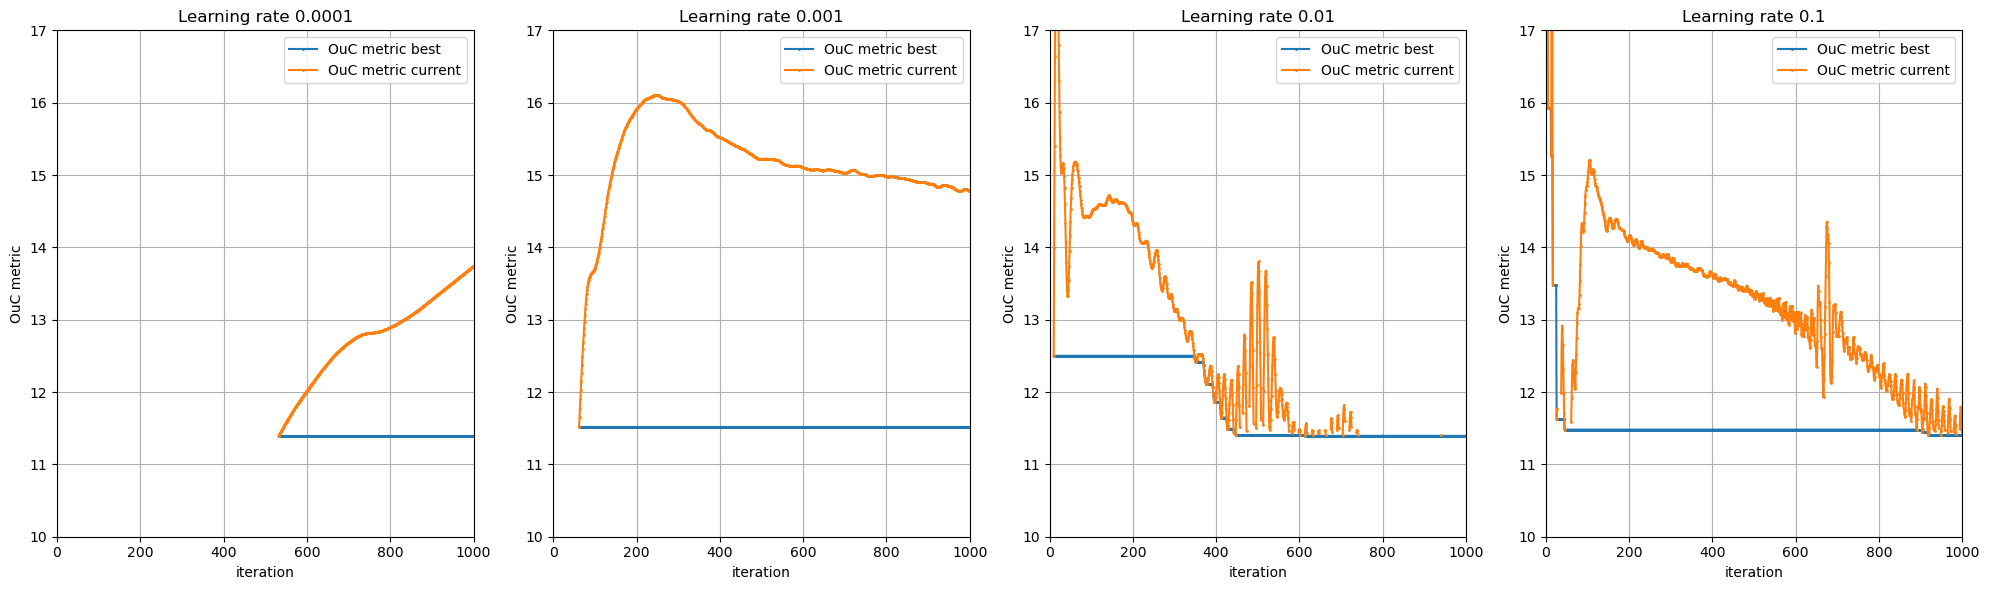

In [32]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 3 columns

y_min = 10
y_max = 17

# Plot on the first subplot
axes[0].plot(res_2_0001['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[0].plot(res_2_0001['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('OuC metric')
axes[0].set_title('Learning rate 0.0001')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlim(0, 1000)

# Plot on the second subplot (assuming similar structure for res_L_2)
axes[1].plot(res_2_001['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[1].plot(res_2_001['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('OuC metric')
axes[1].set_title('Learning rate 0.001')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlim(0, 1000)

# Plot on the third subplot (assuming similar structure for res_L_3)
axes[2].plot(res_2_01['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[2].plot(res_2_01['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[2].set_xlabel('iteration')
axes[2].set_ylabel('OuC metric')
axes[2].set_title('Learning rate 0.01')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(y_min, y_max)
axes[2].set_xlim(0, 1000)

# Plot on the third subplot (assuming similar structure for res_L_3)
axes[3].plot(res_2_1['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[3].plot(res_2_1['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[3].set_xlabel('iteration')
axes[3].set_ylabel('OuC metric')
axes[3].set_title('Learning rate 0.1')
axes[3].legend()
axes[3].grid(True)
axes[3].set_ylim(y_min, y_max)
axes[3].set_xlim(0, 1000)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()